# SigPy for pTx Pulse Design

Welcome to RF pulse design for MRI in SigPy! SigPy is a powerful Python package for signal processing, with an emphasis on iterative methods. Though originally built with an emphasis on iterative reconstruction of MRI images, many of the tools within SigPy and abstractions used by the toolbox ([Linops](https://sigpy.readthedocs.io/en/latest/core_linop.html), [Proximal Operators](https://sigpy.readthedocs.io/en/latest/core_prox.html), [Iterative Algorithms](https://sigpy.readthedocs.io/en/latest/core_alg.html), and [Apps](https://sigpy.readthedocs.io/en/latest/core_app.html)) make it ideally suited for RF pulse design problems. Furthermore, as you will see, many RF pulse design problems are mathematically very similiar to common MRI reconstruction problems! 

Pairing SigPy's reconstruction tools with our new RF pulse designers moves the toolbox closer towards being able to simulate the entire imaging pipeline, from acquisition to recon. In this example, we will demonstrate a pairing of a reduced FOV (rFOV) spatial-domain parallel transmit (pTx) pulse design with gridding reconstruction tools already in SigPy.

# Setup

SigPy can be installed through pip or conda. Please note that many of the features discussed today are found in the [sigpy-rf fork](https://github.com/jonbmartin/sigpy-rf) and are not yet part of the package; they will soon be made available in the [main repository](https://github.com/mikgroup/sigpy).

SigPy is designed to use along with NumPy. In particular, SigPy operates on NumPy arrays directly, and relies on NumPy to provide basic data manipulation functions. Almost aways, we will import NumPy along with SigPy.

In [1]:
%matplotlib notebook
import sys
sys.path.append(r"/home/jonathan/PycharmProjects/sigpy-rf")

# the fundamental sigpy imports: numpy, sigpy (here as submodules), cupy
import numpy as np
import sigpy as sp
import sigpy.plot as pl
import sigpy.mri as mr
import sigpy.mri.rf as rf

# to assist with importing data, we will also import scipy
import scipy.io as sio
import scipy.ndimage.filters as filt
import matplotlib.pyplot as mplib

# for GPU comparison later
import timeit

import ipywidgets as widgets

For our problem, let's say that we are given an 8-channel T/R coil. We will simulate the coil B1+ sensitivities with SigPy: 

<IPython.core.display.Javascript object>


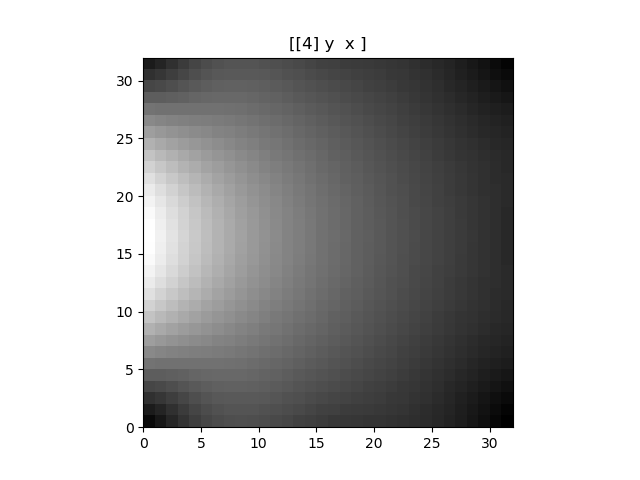

In [2]:
dim = 32
Nc = 8
img_shape = [dim, dim]
sens_shape = [Nc, dim, dim]
sens = mr.birdcage_maps(sens_shape)
pl.ImagePlot(sens)

We will also need some excitation trajectory. For this example, let's design a constant angular velocity spiral. We'll use a variable density spiral designer, but simply set the duration of the full density sampling to be equal to 1 sample. We will then set our "outer region" undersampling rate, R, to be the undersampling rate for the entire spiral. We will also assume some hardware parameters here, that may match our local system, such as maximum slew rate, maximum gradient amplitude, and hardware dwell time.

<IPython.core.display.Javascript object>


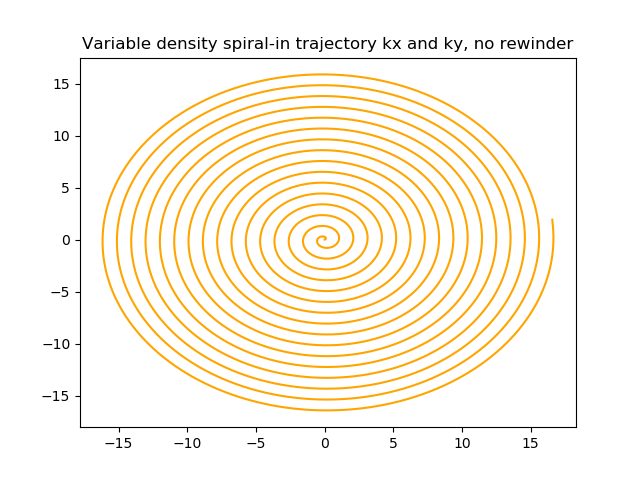

Text(0.5, 1.0, 'Variable density spiral-in trajectory kx and ky, no rewinder')

In [3]:
fov = 0.24  # FOV in m
N = dim  # matrix size
gts = 6.4e-6  # hardware dwell time
gslew = 9000/100  # gradient slew rate in T/m/s
gamp = 3 # maximum gradient amplitude in T/m
densamp = 1  # duration of full density sampling (in samples)
dentrans = 1  # duration of transition from low-high density (in samples)
R = 1.  # degree of undersampling of outer region of trajectory- no undersampling
rewinder = False  # we do not want to include a rewinder in our pulse design trajectory
traj_scaling = 4

# construct a trajectory
g, k, t, s, dens = rf.spiral_varden(fov, N, gts, gslew, gamp, densamp, dentrans, R, rewinder)
#g, k, t, s = rf.spiralarch(fov,N,gts,gslew,gamp)

# Note that this trajectory is a spiral-out trajectory. 
# We will simply time-reverse it to create a spiral-in.
k = np.flipud(k)/traj_scaling

mplib.figure()
mplib.plot(k[:,0],k[:,1], color='orange')
mplib.title('Variable density spiral-in trajectory kx and ky, no rewinder')

Next, let's choose a target magnetization pattern. As a tribute to Vanderbilt, we'll go with a stylized V.

<IPython.core.display.Javascript object>


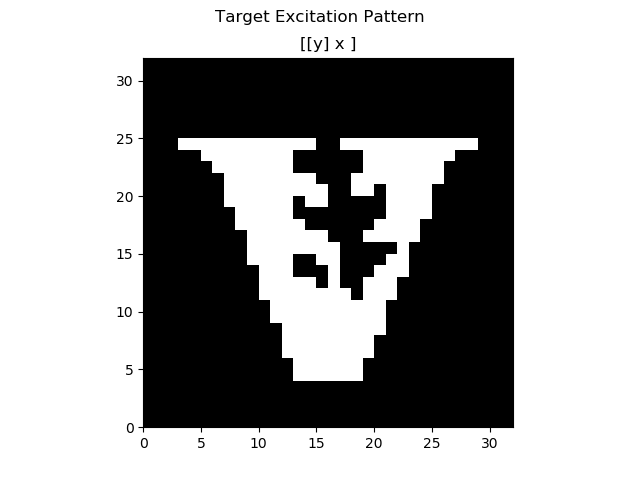

In [4]:
mat_struct = sio.loadmat('data/smallv.mat')
d = mat_struct['d'].astype(np.complex)
pl.ImagePlot(d, title='Target Excitation Pattern')

This is an interesting pattern, but the edges are extremely sharp. To avoid introducing Gibbs ringing into our design, we will perform a very slight blur of the pattern. Our scipy filter requires real-valued numbers, so we will cast to float then cast back

In [5]:
d = d.astype(np.float)
d = filt.gaussian_filter(d, 0.5)
d = d.astype(np.complex)

/home/jonathan/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


Now, lets put these pieces together and design our pulses using SigPy, and plot.

<IPython.core.display.Javascript object>


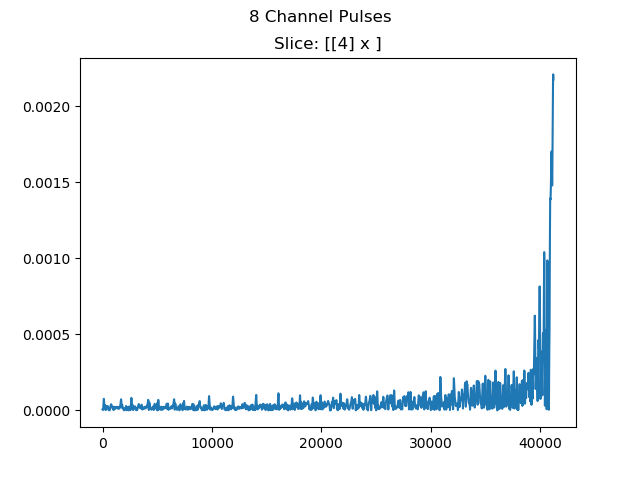

In [6]:
pulses = rf.stspa(d, sens, k, gts, alpha=1000, max_iter=100, tol=1e-7, phase_update_interval = 10, explicit=False)
pl.LinePlot(pulses, title = '8 Channel Pulses')

Let's check that our pulse designer did a reasonable job. We can do this by constructing the system matrix A hidden within the SmallTipSpatialPulseDesign app, and looking at $$ m = A b$$

<IPython.core.display.Javascript object>


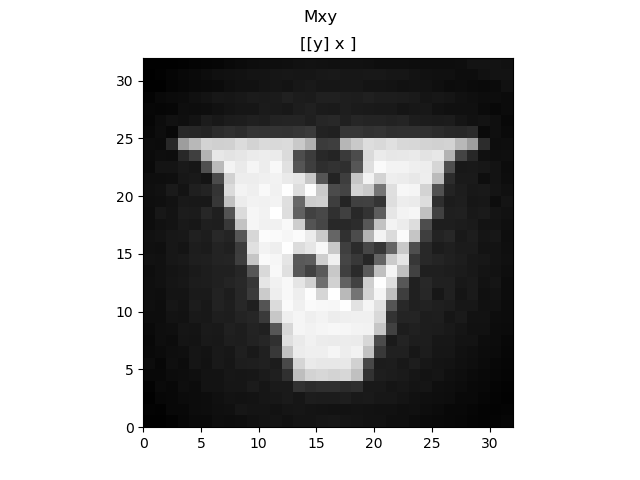

In [7]:
A = mr.linop.Sense(sens, coord=k, ishape=d.shape).H

m = A * pulses

pl.ImagePlot(m, title = 'Mxy')

And as a sanity check, let's see what magnetization we get using SigPy.RF's parallel transmit Bloch simulator. This function takes in our B1+, our gradients, any B0 inhomogeneity we may wish to consider, and our sensitivity maps and returns our predicted longitudinal and transverse magnetizations.

In [8]:
#make spatial variables
x, y = np.ogrid[-img_shape[0] / 2: img_shape[0] - img_shape[0] / 2,
       -img_shape[1] / 2: img_shape[1] - img_shape[1] / 2]

spatial = np.zeros((dim*dim,2))
i = 0
for ii in range(dim):
    for jj in range(dim):
        spatial[i,1] = x[ii,0]
        spatial[i,0] = y[0,jj]
        i += 1

# pTx Bloch Simulation. Note that we must also make our gradient spiral-in to be consistent
a, b, m, mz = rf.abrm_ptx(pulses, spatial/(dim*traj_scaling), np.flipud(g), gts, fmap=None, sens=sens)

<IPython.core.display.Javascript object>


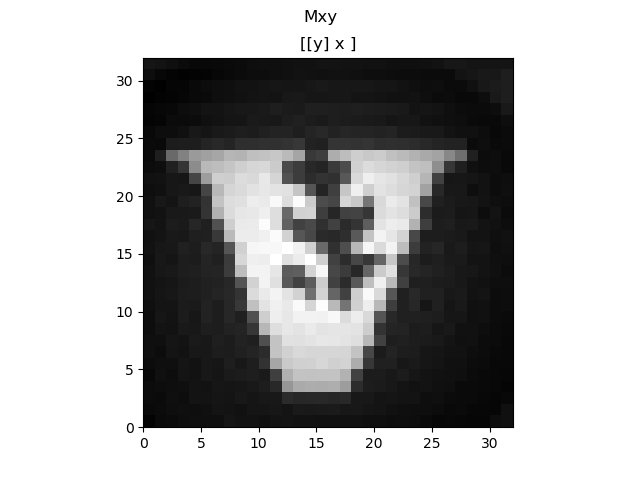

In [9]:
pl.ImagePlot(np.fliplr(np.rot90(np.reshape(m,img_shape))), title=('Mxy'))

And now that we have it, we can look at our Mz longitudinal magnetization profile as well:

<IPython.core.display.Javascript object>


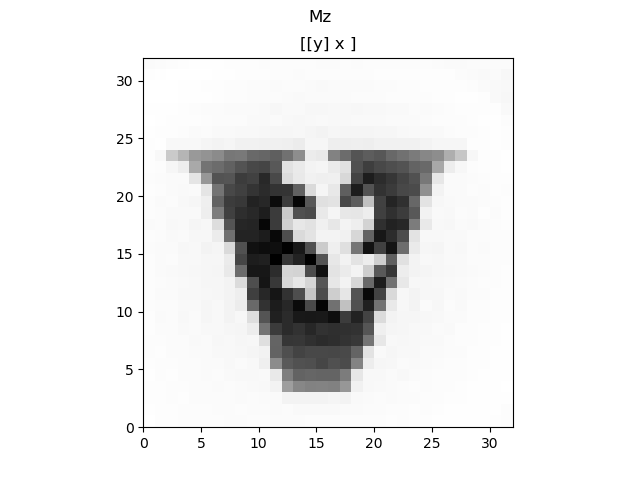

In [10]:
pl.ImagePlot(np.fliplr(np.rot90(np.reshape(mz,img_shape))), title=('Mz'))

Great! It looks like simulation confirms our magnetization pattern. However, SigPy also allows us to accelerate our computation by using GPU's or multiple CPU's. Let's see if we can speed up our pulse design by performing computation with a local GPU.

There are a number of ways of doing this (see SigPy's documentation), but one direct way is to simply move the arrays you wish to use within fast computation to the GPU. 



In [ ]:
d_gpu = sp.to_device(d,0)
sens_gpu = sp.to_device(sens,0)
k_gpu = sp.to_device(k,0)

We can quickly compare execution times using Jupyter's %%timeit magic function. For this problem, we see a huge speedup even for a small matrix size. 

In [ ]:
%%timeit
pulses = rf.stspa(d, sens, k, gts, alpha=1000, max_iter=100, phase_update_interval = 10, explicit=False)

In [ ]:
%%timeit
pulses_gpu = rf.stspa(d_gpu, sens_gpu, k_gpu, gts, alpha=1000, max_iter=100, phase_update_interval = 10, explicit=False)

This speed increase allows us to compute pulses for demonstration very rapidly. For example, we can play around with interactively controlling our peak pulse power. This is done internally within the function by a Primal Dual Hybrid Gradient optimization method.

In [ ]:
@widgets.interact(constraint=(0.01,1,0.01))
def plot(constraint=1):
    pulses_gpu = rf.stspa(d_gpu, sens_gpu, k_gpu, gts, alpha=1000, max_iter=100, pinst=constraint/1000, phase_update_interval = 100, explicit=False)
    mplib.ylim=(0,0.025)
    pl.LinePlot(pulses, title='Power Constrained Pulses')


 # Building a Small-Tip Spatial Domain App

Finally, let's look at making a very simple version of the small-tip spatial-domain pTx pulse designer in the highest level of SigPy abstraction: the [App](https://sigpy.readthedocs.io/en/latest/core_app.html). We'll do this without any of the fancy constrained optimization, off-resonance correction, regularization, or other features that are included in the stspa() small-tip designer above; just the bare bones of a pTx designer to illustrate the App building process (and how so many of our pulse design functions can take advantage of existing recon code!).

This code demonstrates many of the key SigPy abstractions firsthand:

* the Linop
* the Alg
* the App

In [ ]:
class SpatialPtxPulses(sp.app.App):
    def __init__(self, target, sens, coord, pulse_in,
                 max_iter=300, tol=1E-6, show_pbar=True):
                
        self.target = target
        self.sens = sens
        self.coord = coord
        self.pulses = pulse_in
        self.max_iter = max_iter
        self.tol = tol
        self.show_pbar = show_pbar
        
        device = sp.get_device(target)
        self.device = sp.Device(device)
                
        # Our system matrix for this problem is SENSE's A.H.
        # Sigpy provides this matrix as a Linop already:
        A = mr.linop.Sense(self.sens, self.coord, ishape=self.target.shape).H
        
        # solving A.H * A * pulses = A.H * m
        with self.device:
            self.alg = sp.alg.ConjugateGradient(A.H*A, A.H*self.target, self.pulses,
                                                max_iter=max_iter, tol=tol)

        super().__init__(self.alg, show_pbar=show_pbar)

    def _summarize(self):
        if self.show_pbar:
            self.pbar.set_postfix(resid='{0:.2E}'.format(self.alg.resid))

    def _output(self):
        return self.pulses

Let's run our app twice over: once using CPU, once using GPU:

In [ ]:
pulses_in_cpu = np.zeros((sens.shape[0], k.shape[0]), np.complex)
pulses_in_gpu = sp.to_device(pulses_in_cpu,0)

pulses_out_cpu = SpatialPtxPulses(d, sens, k, pulses_in_cpu).run()
pulses_out_gpu = SpatialPtxPulses(d_gpu, sens_gpu, k_gpu, pulses_in_gpu).run()